# Automatic model building and model selection with startml

In this notebook, we will train a number popular machine learning algorithms in a regression problem to estiamte house prices. 

The data set was provided by Kaggle, and is one of the long standing data sets in the playground section. 

startml currently supports hyperparameter tuning of 3 algorithms, random forest, gradient boosted machine, and deep learning. In this notebook, we will:

* Automatically train a number of different machine learning algorithms through hyperparameter grid searches
    
* Apply a performance threshold to filter the resulting models
    
* Visualize the model performance and training information
* Select one best model 
* Make Predictions with the selected model. 

## Load startml 

In [1]:
#==================================================================
# load the startml library
#==================================================================
library(startml)

Loading required package: Metrics
Loading required package: ggplot2
Loading required package: reshape2
Loading required package: plyr
Loading required package: gridExtra
Loading required package: plotly

Attaching package: ‘plotly’

The following objects are masked from ‘package:plyr’:

    arrange, mutate, rename, summarise

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: tsne
Loading required package: htmlwidgets
Loading required package: h2o

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------

In [2]:
#=============================================================================
# Launch an h2o instance 
# Load in the data downloaded from Kaggle Playground
#=============================================================================

# launch an h2o instance, max ram and number of threads can be set 
# here, I just use the defaul
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpF407GW/h2o_andrewrs_started_from_r.out
    /tmp/RtmpF407GW/h2o_andrewrs_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 887 milliseconds 
    H2O cluster version:        3.16.0.1 
    H2O cluster version age:    2 months and 26 days  
    H2O cluster name:           H2O_started_from_R_andrewrs_hzh146 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.46 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.2 (2017-0

In [3]:
#=============================================================================
#
# Load in the data downloaded from Kaggle Playground
#
#=============================================================================


# use the h2o import to creat an h2o object. This is important 
#   as there is a lot going on behind the scenes in h2o, and R is only 
#   the interface.
train <- h2o.importFile("../../../data/train.csv")
test <- h2o.importFile("../../../data/test.csv")

# print out the dimenations of train and test 
tn_dim <- dim(train)
tt_dim <- dim(test)

# build message with extras
message <- c('train: a 2D h2oFrame with shape: [', tn_dim, ']\n', 'test: a 2D h2oFrame with shape: [', tt_dim, ']')

# print to consol
cat(message)

  |======================================================================| 100%
  |======================================================================| 100%
train: a 2D h2oFrame with shape: [ 1460 81 ]
 test: a 2D h2oFrame with shape: [ 1459 80 ]

## Data Exploration

H20 provides a few ways to visualize data through the R api which can be helpful. Since this data set has been "pre-cooked" you can just begin modeling if you want. Generally, this is not the case. Here, I used a few of the built in vizualization functions in the h2o library to look at the data. These functions are designed to work with pretty big data sets, which is why they use binning so much. We dont need it here, as there are only about 1500 rows, but I'll do it anyway to show the style of figure you can get out of really big data sets with these functions.  

In [5]:
#=============================================================================
#
# Using h2o fucntion to visualize the data
#
#=============================================================================

# lets print out the column names of train, you can do it the same way as a dataframe
colnames(train)

[1] "Id"            "MSSubClass"    "MSZoning"      "LotFrontage"  
 [5] "LotArea"       "Street"        "Alley"         "LotShape"     
 [9] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
[13] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[17] "HouseStyle"    "OverallQual"   "OverallCond"   "YearBuilt"    
[21] "YearRemodAdd"  "RoofStyle"     "RoofMatl"      "Exterior1st"  
[25] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[29] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[33] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[37] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[41] "HeatingQC"     "CentralAir"    "Electrical"    "1stFlrSF"     
[45] "2ndFlrSF"      "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[49] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[53] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[57] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[61] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[65] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[69] "EnclosedPorch" "3SsnPorch"     "ScreenPorch"   "PoolArea"     
[73] "PoolQC"        "Fence"         "MiscFeature"   "MiscVal"      
[77] "MoSold"        "YrSold"        "SaleType"      "SaleCondition"
[81] "SalePrice"

### Cut out a few columns

Now, I'll cut out a few columns that are difficult to split well into train, valid, test. Again, stratified splits or some other better way will be incorperated into a later version of startml. I know this from running this notebook a few times, in real applications this info may come from a little trial and error

In [9]:
#=============================================================================
#
# Cut out a few columns of the training data
#
#=============================================================================

# you can interact with h2oFrames mostly the same way you interact with dataframes


labeled_data <- train[,!names(train) %in% c('Exterior1st', 'Exterior2nd', 'KitchenQual','Functional',  'SaleType', 'MSZoning')]
newdata <- test[,!names(test) %in% c('Exterior1st', 'Exterior2nd', 'KitchenQual','Functional',  'SaleType', 'MSZoning')]


# check number of columns 
message <- c('Now we are down to ', ncol(labeled_data), ' columns', "in train and \n", ncol(newdata), "in test")
cat(message)
colnames(labeled_data)

Now we are down to  75  columns in train and 
 74 in test

[1] "Id"            "MSSubClass"    "LotFrontage"   "LotArea"      
 [5] "Street"        "Alley"         "LotShape"      "LandContour"  
 [9] "Utilities"     "LotConfig"     "LandSlope"     "Neighborhood" 
[13] "Condition1"    "Condition2"    "BldgType"      "HouseStyle"   
[17] "OverallQual"   "OverallCond"   "YearBuilt"     "YearRemodAdd" 
[21] "RoofStyle"     "RoofMatl"      "MasVnrType"    "MasVnrArea"   
[25] "ExterQual"     "ExterCond"     "Foundation"    "BsmtQual"     
[29] "BsmtCond"      "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"   
[33] "BsmtFinType2"  "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"  
[37] "Heating"       "HeatingQC"     "CentralAir"    "Electrical"   
[41] "1stFlrSF"      "2ndFlrSF"      "LowQualFinSF"  "GrLivArea"    
[45] "BsmtFullBath"  "BsmtHalfBath"  "FullBath"      "HalfBath"     
[49] "BedroomAbvGr"  "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"   
[53] "FireplaceQu"   "GarageType"    "GarageYrBlt"   "GarageFinish" 
[57] "GarageCars"    "GarageArea"    "GarageQual"    "GarageCond"   
[61] "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"   "EnclosedPorch"
[65] "3SsnPorch"     "ScreenPorch"   "PoolArea"      "PoolQC"       
[69] "Fence"         "MiscFeature"   "MiscVal"       "MoSold"       
[73] "YrSold"        "SaleCondition" "SalePrice"

### Look at the sale year and sale price

Doesn't seem to be a lot of correlation. Interestingly, the most expensive house was bought in 2007 before the housing crisis, but it looks like more houses over half a million were bought post 2008. In general its hard to see any correlations.

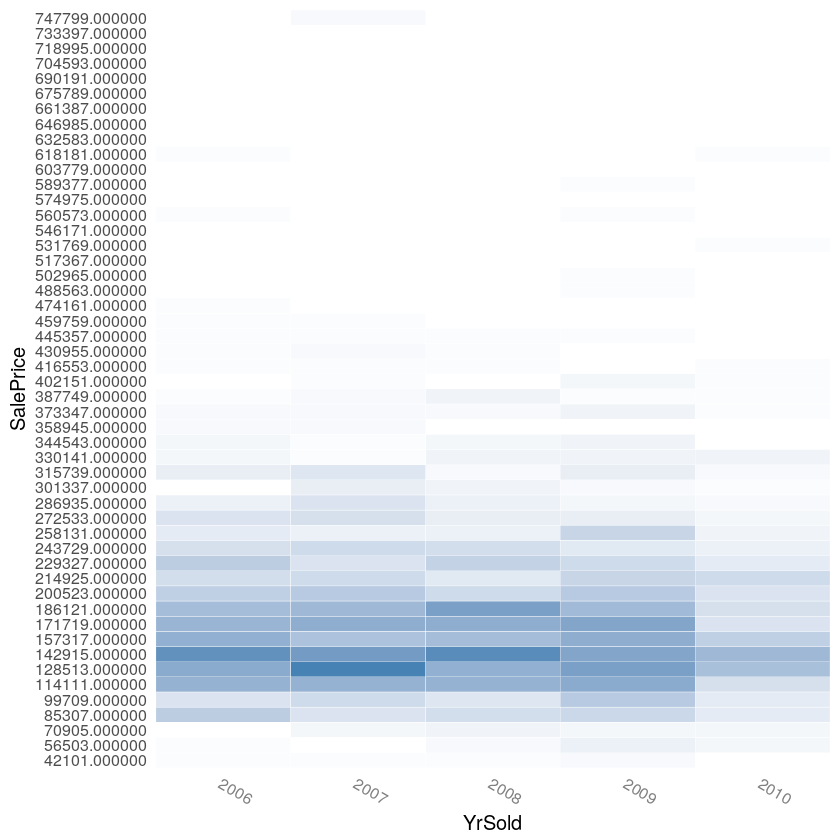

In [7]:
# since sale price is the target variable lets plot a couple of input variables with respect
#   to SalePrice 
plot(h2o.tabulate(train, "YrSold", "SalePrice"))

### Look at the sale month and sale price

It looks like most houses are sold in warmer months, may june and july. Its possible that there is a postive correlation where houses sold later through the high volumen months sell for more, but its hard to say with confidence from this overview plot. Also, it looks like no houses over half a million were sold between august and december, while the month with the most highest price sales is july. 

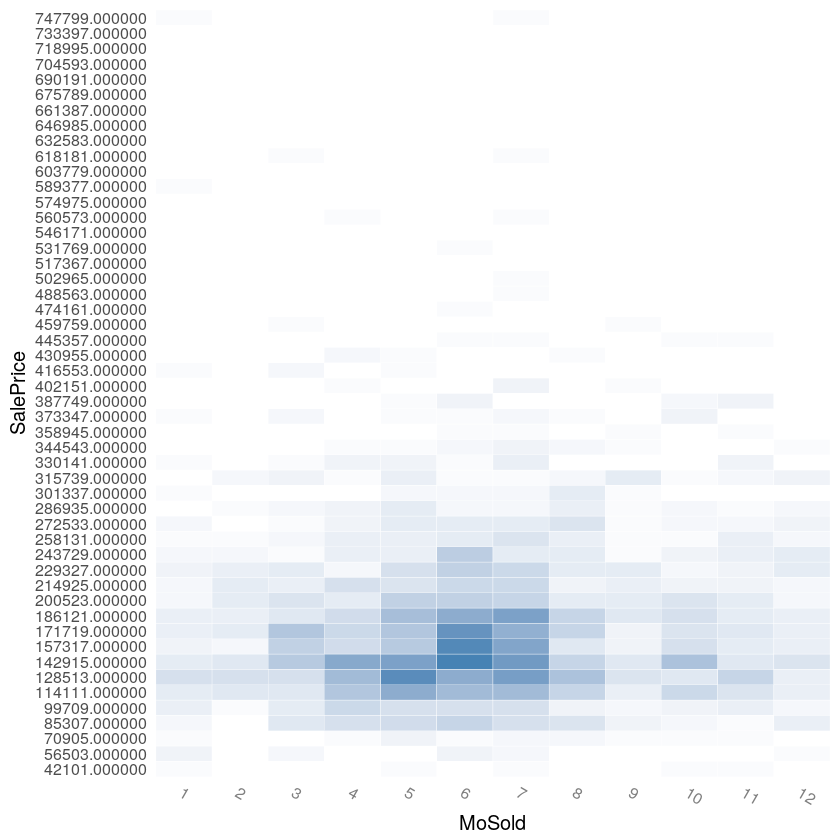

In [8]:
# Try the month sold
plot(h2o.tabulate(train, "MoSold", "SalePrice" ))

### Overall condition and sale price

Looks like most houses are in condition 5 / 10. I guess thats not surprising. Houses in this condition have a wide range of sale prices. I think you really can see a positive collelation overall, with an increasing condition rising with sale price, although there is lots of variance. 

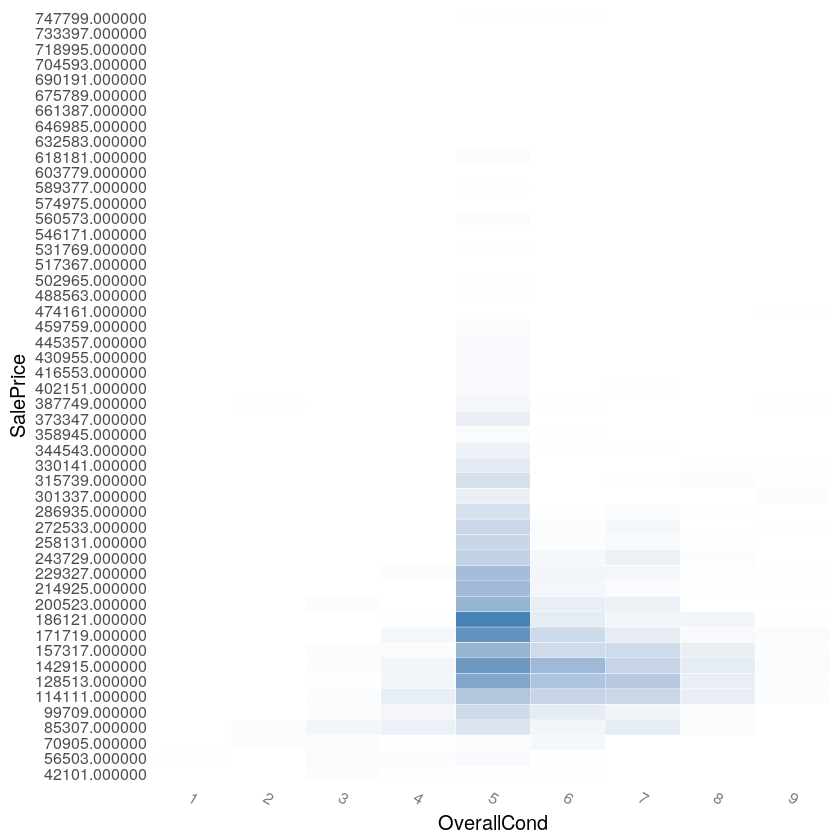

In [9]:
# overall condition is probably important
plot(h2o.tabulate(train, "OverallCond", "SalePrice"))

### Garage car capacity and sale price

This one is interesting. There seems to be a strong postive correlation between garage car capacity and sale price, compared to the other relationships we've seem so far. If you read the meta-data about the training set, then you know there houses are located in and around Ames, Iowa USA. Iowa is a very rural state, and ames is not a big city. Public transportation is likely not a realistic option for most people. Those looking to buy a new house in this area put a lot of value on the ability to store more vechicles in a covered garage.  

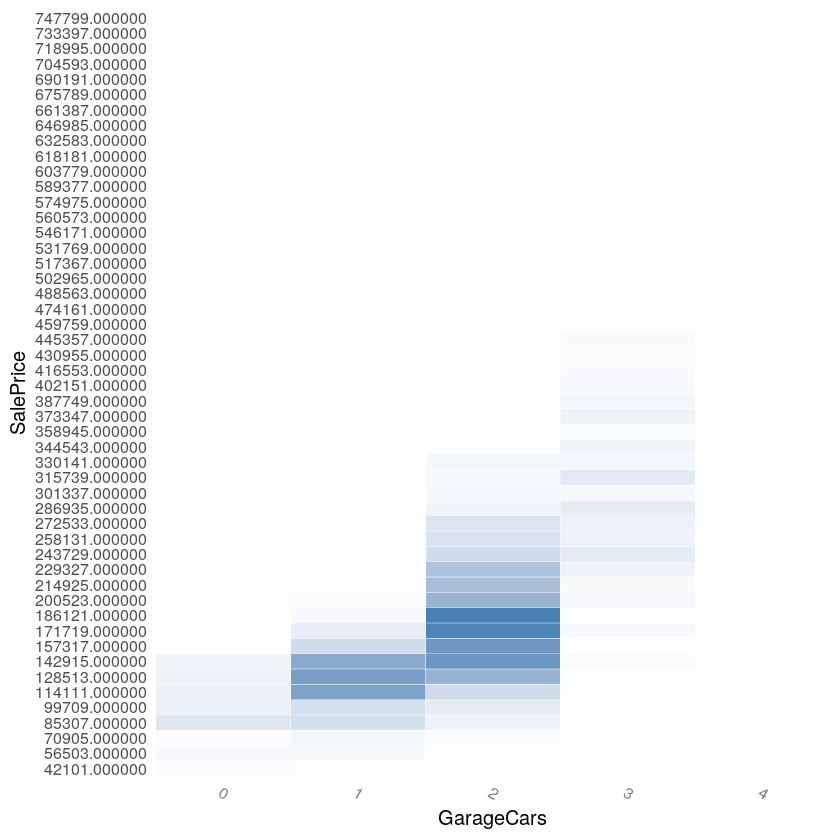

In [10]:
# Now the garage size 
plot(h2o.tabulate(train, "GarageCars", "SalePrice" ))

## Run startml

A few things happen when you run startml: 
* The labeled data is split into training, validation, and testing sets.
* the algorithms you selected are trained one type at a time
    * A grid search provided by h2o is used to train many models
    * These models are saved into the output object, which is an mlblob class. 
    * Additionally, each model is saved onto the disk, incase of run failures on long training sessions. 
    * Each model is evaluated separately on the test set
* Predictions of each model on train, validation, test, and newdata are saved to the output mlblob object

---

The inputs are as follows:
* **labeled_data** -> this is the collection of labeled data that will be used train, validate, and test the models. It is an h2oFrame object, which mentally is similar to an R dataframe, but it exists on the h2o cluster inililized earlier. This allows for scalling to multi-node clusters and big data.
* **newdata** -> newdata is a h2oFrame object containing input variables but no labels. If this argument is left empty, no predictions will be made, but the models will still be trained and tested. If it is present, all the models trained will be used to make predictions, or those which satisfy the threhold arguments
*  **label_id** -> text object. name of the id column in training and  newdata that you want to leave out of the analysis. If you have a integer varialbe that idenfies observations and you leave it in, you can create false correlations and worthless models. This does not delete the column, just never trains any models on it. It will still be there in the output to identify predictions. 
* **y** -> A text object defining the name of the target column, the one you are training to predict.
* **x** -> A string of text objects defining the input variables by labeled data column name which will become inputs in all the models. If not used, then all columns will be used for training except the label id column, if specifed. 
* **algorithms** -> string of text objects defining which algorithms to train. Can be any of or any combination of "deeplearning", "randomForest", and "gbm". Naming conventions adopted from h2o for consistency. 
* **split_seed** the random seed which is used to split the data into train, validation, and test sets. This is incluced in an effort to make the startml process more repeatable. In general, h2o training and model building on the h2o cluster is not perfectly repeatable. This is still under construction, as ideally smarter data splits would be available. For now, consider this limiation in how data is split when building your labeled data set. 
* **runtime_secs** -> the total number of seconds each grid search will use when training algorithms. For example, if you were training just deep learning algorithms, and you set runtime_secs to 60, then startml would perform 1 grid search lasting 60 secs. If however, you wanted to train deep learning and random forest models, then startml would perfom 2 grid searches each lasting 60 secs totaling 2 minutes. 
* **eval_metric** -> the evaluation metric used for training and testing models. Right now, startml only supports regression and binary classification, and can use "RMSE", "RMSLE", "cross_entropy" "MSE", "MAE", "AUC", and a few other metrics.
* **other arguments** -> there are a few others, which I have left out here for brevity. More in the official documentation. 

In [10]:
#===============================================================
# Run startml 
#
#===============================================================

# here we only train 3 types of algorithms for 60 grid searches each. 
# This will total 3 minutes of grid search
output <- startml(labeled_data = labeled_data,
                  newdata = newdata,
                  label_id = 'Id',
                  y = 'SalePrice',
                  algorithms =c("deeplearning", "randomForest", "gbm"),
                  split_seed = 1234,
                  runtime_secs = 20, # run it a very short time for this example
                  eval_metric = "RMSLE"
)


Training Deep Learning Models
  |======================================================================| 100%
Deep Learning Models Saved To:
 /home/andrewrs/Desktop/github/startml/examples/notebooks/selecting_best_model/dl_models 

Training Random Forest Models
  |======================================================================| 100%
Random Forest Models Saved To:
 /home/andrewrs/Desktop/github/startml/examples/notebooks/selecting_best_model/rf_models 

Training Gradient Boosting Models
  |======================================================================| 100%
gbm Models Saved To:
 /home/andrewrs/Desktop/github/startml/examples/notebooks/selecting_best_model/gbm_models 


Saving Train Predictions with Selected Models
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |===================

## Plot the Training Results

startml has a built in overview plot to see the results of training the models 
and the test performance. Just use plot on the mlblob output from the startml function. Its worth noting that this plot function doesn't work yet with very big data sets, and thus is limited by your workstation capabilities. Although the startml function itself is capable of running on big data sets thanks to the h2o backend, the plot function here still needs a lot of ram. I am working on this in future versions so you can still use the plot function on very big (not in ram) data sets. 

No id variables; using all as measure variables


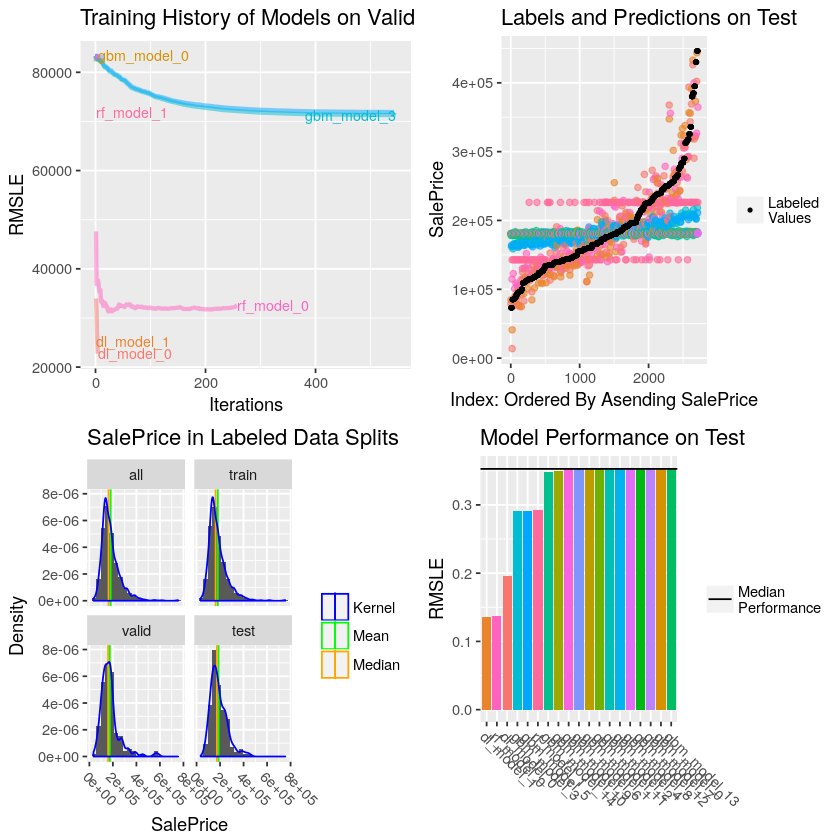

In [11]:
#===============================================================
# Plot the results from training.  
#
#===============================================================

plot(output)

## Trimming

There's alot going on even after only 1 minutes of model building. To fix this, we will trim poorly performing models with the trim function. If you don't know where to start, take a look at the median performance line and decide from there. For this example, I'm going to pick only models that did a lot better than the median. So, I'll trim down to models with RMSLE 0.3 or better on the test data. 

Also, I don't really care about very similar models either, so I set a correlation threshld of 0.95. This will pick only one model when two models test predictions have pearson correlation of greater than 0.95. 

In [13]:
#==============================================================================================
# Triming models based on eval metric and correlation. 
#
#===============================================================================================

# trim a few models
trim_out <- trim(output,
                  eval_metric = 'RMSLE',
                  eval_threshold = 0.3, 
                  correlation_threshold = 0.95)


Choosing Models on Test based on Performance and Correlation Thresholds
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |============================================

## Plotting the trimmed result

So, we'll plot the trimmed output:

No id variables; using all as measure variables


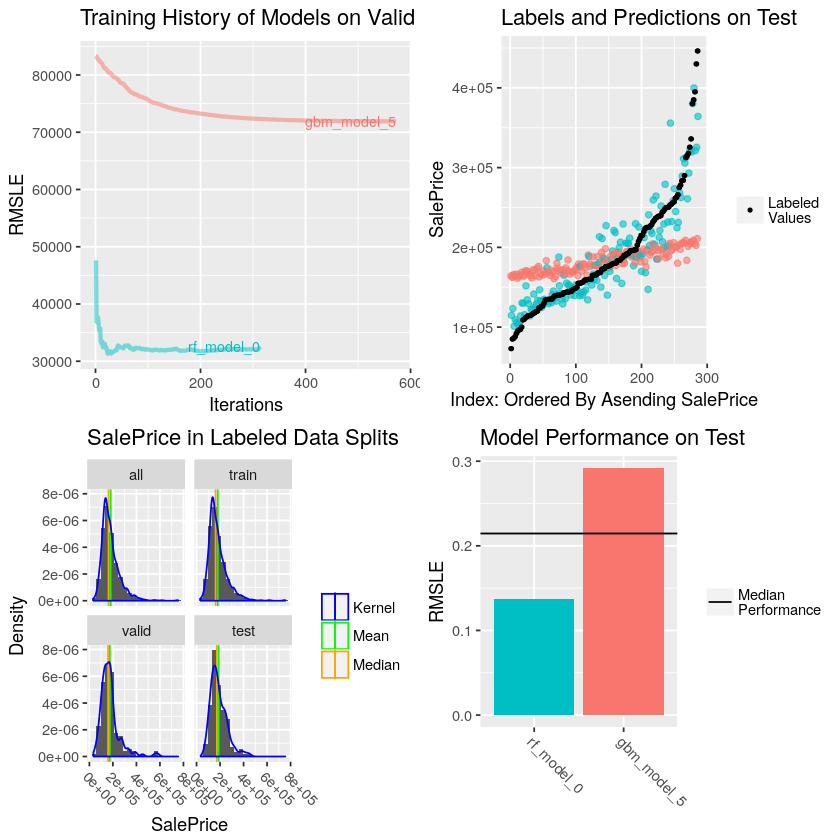

In [14]:
#==============================================================================================
# plotting the trimmed result
#
#===============================================================================================

plot(trim_out)

## Iterative Trimming

Based off the top right subplot, we can see one of the random forest models (rf_model_1) that made it through our threshold controls is a stupid model. Even though it scored much better than many others, it simply found a sub-optima where producing one of two values based on the inputs got a RMSE of slightly below 60000. This was hard to see before with all the clutter, but now that it is obvious, we will send this object back through the timmer. This time, we wont use the correlation threshold. 

In [15]:
#==============================================================================================
# Triming models again.  
#
#===============================================================================================

# trim a few models
trim_out <- trim(trim_out,
                  eval_metric = 'RMSLE',
                  eval_threshold = 0.15)


Choosing Models on Test based on Performance and Correlation Thresholds
  |======================================================================| 100%
  |======================================================================| 100%


## Plotting the re trimmed resut

So, we'll plot one more time

No id variables; using all as measure variables


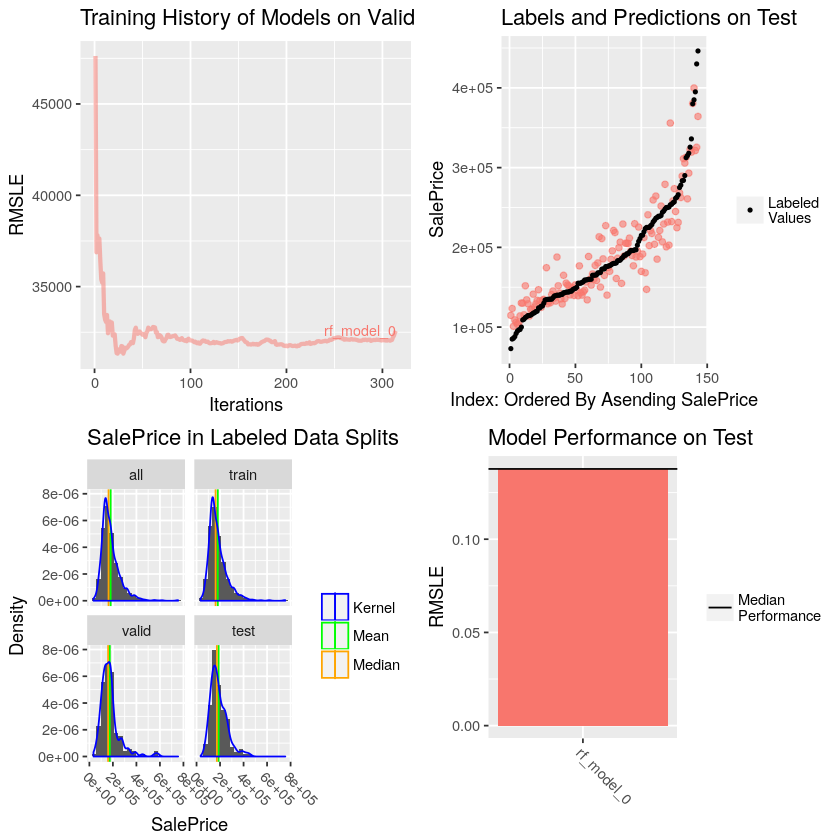

In [16]:
#==============================================================================================
# plotting the trimmed result
#
#===============================================================================================

plot(trim_out)

## Evaluating the Remaining Models

From about 40 or so models, we are down to two. the random forest model has performed much better than the gbm model,
but it can be worth taking taking a look at both. From the top right plot, you can see the random forest model seems 
to have learned something about the structure of the data and is providing reasonable estiamtes that begin to
approximate the actual shape of the test data. The gbm model however, does not seem to have yet learned 
enough to make reasonable predictions. Its predictions capture some of the processes dictating housing prices, but
arnet good enough to really use. 

## Selecting One model and Looking Further

So, I've have automatically tuned over 40 models including deep learning, random forest, and gradient boosted machine algorithms. The majority of these models were not very good. Through iterative trimming, we selected random forest model as the best. We can now get the new data predictions from this model, or grab the model out of the mlblob object for further analysis. At this point, I can just treat the model like you trained it using the h2o interface only. 

H2O offers a lot of options for looking into models, they are pretty complex objects all by themselves. What the model object looks like depends on what algorithm it is, and what kind of problem it was trained on. Since the model I'm looking into is a random forest, the object includes a few extras like variable importances out of the box. 

In [7]:
#=====================================================================================
#
# Save the best model predictions and go further with the seected model
#
# 
#=====================================================================================

# The rf_model_0 is still on the h2o cluster before and after this command. 
#  here, we just grab it out into a new object to work with it easily. 
#  You get "rf_model_0" right off the summary graph of the mblob object
best_model <- h2o.getModel('rf_model_0')

# take a look at the model summary to see final parameters and more info on performance
summary(best_model)

Model Details:

H2ORegressionModel: drf
Model Key:  rf_model_0 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            2752                     2752             1192804         5
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    5.00000         18         32    29.33794

H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  1043960598
RMSE:  32310.38
MAE:  19609.82
RMSLE:  0.1697414
Mean Residual Deviance :  1043960598


H2ORegressionMetrics: drf
** Reported on validation data. **

MSE:  1062094542
RMSE:  32589.79
MAE:  18890.82
RMSLE:  0.1722092
Mean Residual Deviance :  1062094542




Scoring History: 
            timestamp   duration number_of_trees training_rmse training_mae
1 2018-02-17 12:48:22  0.010 sec               0                           
2 2018-02-17 12:48:22  0.406 sec               1   50843.22802  30630.88108
3 2018-02-17 12:48:22  0.

## Visualizing the Training Process in more depth

Although the plot function in startml shows the validation training for as many models as fit on the figure, it is a good idea to to take a closer look at the training process for models which will be potentially selected. For the random forest model, I'm taking a look at the training and validation loss scores over number of weak learners, or number of trees, built. 

Looks like I could have used a harder early stop. Interestingly, the MAE is actually lower for the validation set, which is not ideal. Usually I'm looking for training to be a little bit better than validation, indicating a small amount of goodness of fit loss between training and validation. It doesn't nessesarily mean the model is bad, but generally something a bit suspect in my oppinion. I this case, I bet its from having such a small data set. With small data sets the scores can be better for the validation sometimes just becase the small set may not reprsent all the troubles encountered in the larger training set. Looking back at the traing, validation density plots in the bottom left of the plot output, you can see the validation distribtion is more likely to have lower-mid range prices in a random sample than the training data. In the upper right plot, the observed and predicted, I can see that the selected random forest model might be generally better at making predictions in the lower-mid range.

When comparing two different fit metrics its also a good idea to remember how the are related to eachother. For example, for the same data sets, mae is less than or equal to rmse. Also, rmse has greater penalty for larger errors than mae, so food for thought while considering the training history. In this example, small data and not having enough examples across the sale prices in each data set split is probably the cause. In the future, I'm planning on making better data separations built-in to startml, but for now I'll just move on with this model for the example. 

Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”

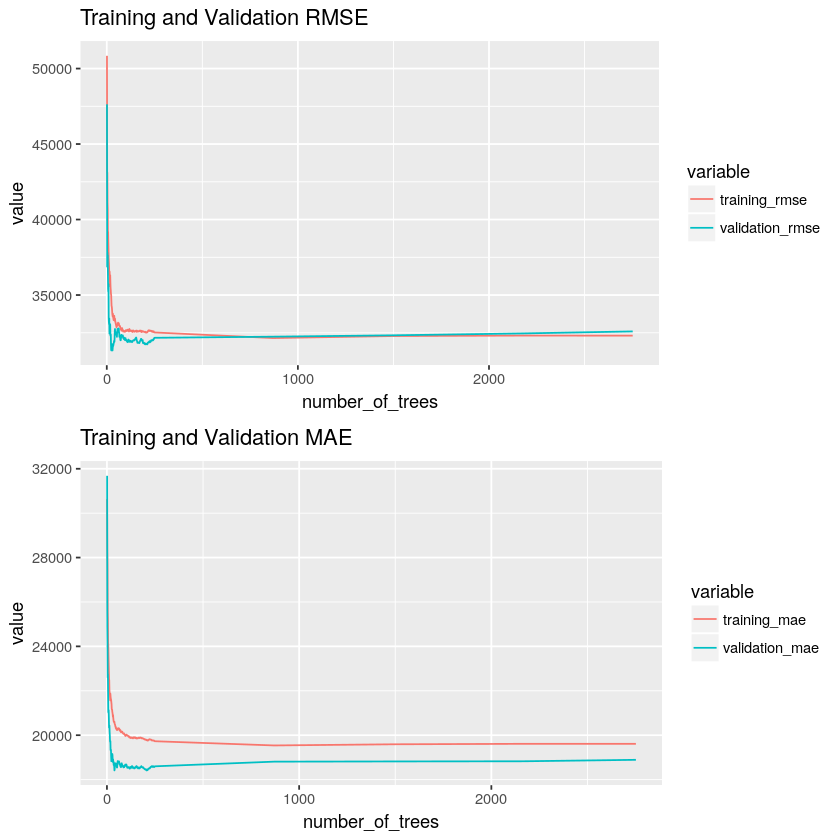

In [8]:
#========================================================================
# 
# Plot the train and validation history for the selected model 
#
#========================================================================

# make a dataframe out of the training history frame from the h2o model object 
# H2O only saves RMSE and MAE for training history in this model

hist <- best_model@model$scoring_history

# make a plot of rmse for validation and training, and add in a color chaning with the variance
#training_deviance
#validation_deviance

hist_melt_1 = melt(hist[,c(3, 4, 7)], id = 1)
hist_melt_2 = melt(hist[,c(3, 5, 8)], id = 1)

p1 = ggplot(hist_melt_1) + 
    geom_line(aes(x = number_of_trees, y = value, color = variable)) +
    ggtitle('Training and Validation RMSE')

p2 = ggplot(hist_melt_2) + 
    geom_line(aes(x = number_of_trees, y = value, color = variable)) + 
    ggtitle('Training and Validation MAE')

# plot top - bottom
grid.arrange(p1, p2, ncol = 1, nrow = 2)


    



### Variable importances 

H20 includes a function to look at variable importances in different algorithms. Here I can see importance information for these variables in a nice looking table. Looking at the far right column, the "OverallQual" (overall quality) of the houses was a pretty important variable when predicting the price according to the random forest model, while "YrSold" (year the house was sold) was not very important to the price. Garage car capacity was also important in determining sale price. Its good news that these findings echo some of what I thought while looking at the training data before the modeling process. 

In [55]:
#========================================================================
# 
# Explore variable importances
#
#========================================================================

# take a look at the variable importances. 
h2o.varimp(best_model)

variable,relative_importance,scaled_importance,percentage
OverallQual,4.031006e+15,1.000000000,0.302908534
ExterQual,1.949982e+15,0.483745793,0.146530729
GarageCars,1.409448e+15,0.349651747,0.105912498
GrLivArea,1.212128e+15,0.300701068,0.091084919
Neighborhood,1.171789e+15,0.290693886,0.088053659
TotalBsmtSF,4.584283e+14,0.113725552,0.034448440
YearBuilt,4.247206e+14,0.105363426,0.031915481
BsmtQual,3.554684e+14,0.088183564,0.026711554
1stFlrSF,3.174286e+14,0.078746740,0.023853060
GarageArea,3.111750e+14,0.077195381,0.023383140


## Making predictions with the best model

I fed in newdata when launching startml in this notebook, so, the predictions for that set are already in the mlblob object "output". 

Theres a function in startml to make an h2oFrame or regular R dataframe with the predictions I want. For this small data set, we can load the final predictions right into the R workspace. For bigger data, you should not do this, and leave the object as an h2oFrame. 

In [26]:
#==============================================================================
#
# Get predictions from best model in a dataframe
#
#
#==============================================================================

# making predictions with the best model into H2O dataframe.
#newdata_predictions <- get_prediction('rf_model_0', output)

# make a regular data frame of the predctions with the ids from the original file if small enought 
#predict_out <- data.frame(Id = as.data.frame(newdata$Id), Predictions = as.data.frame(newdata_predictions[[1]]$predict))

# print out to csv
#write.csv(predict_out, 'rf_model_o_newdata_predictions.csv', quote = FALSE, row.names = FALSE)

# view it 
predict_out

Id,predict
1461,131327.2
1462,144076.1
1463,181239.6
1464,182871.2
1465,213837.3
1466,184089.9
1467,167665.3
1468,176853.0
1469,176485.7
1470,131498.0


In [8]:
# experiments with dask and datashader 

h2o.exportFile(train, 'vis_data/test.csv', force = TRUE, parts = -1)

  |======================================================================| 100%
